In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import calendar
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

In [3]:
groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [4]:
groups = generate_groups_data_flat(data, groups_input, seasonality=12, h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [6]:
groups = generate_groups_data_matrix(groups)

In [1]:
import pymc3 as pm
import theano.tensor as tt
import theano
import numpy as np
from libs.pre_processing import generate_groups_data_matrix_minibatch, generate_groups_data_matrix

'''
Features:
1. The levels of the hierarchy that are used in the estimation 
    (i.e. considered to generate new gaussian processes) - 
    fewer levels don't use all the potential information 
    nested in the hierarchies but can boost performance
2. The seasonality to consider (i.e. the periodic 
    kernel defined for the cov function of the GP)
3. Option to define a piecewise function for the GP mean and respective
    selection of the number of changepoints
4. Option to define a linear function (defined as log linear considering 
    the log-link function used with the Poisson distribution)
5. Option to use MAP or VI to estimate the parameter values (VI is advised)
6. Possibility to use Minibatch that ensures scalability of the model
'''

class LogLinear(pm.gp.mean.Mean):
    # Log linear mean function to get diminishing returns on the mean 
    # -> adding 1 to avoid inf when X = 0
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(tt.log(X+1), self.b) + self.a)


class Linear(pm.gp.mean.Mean):
    # This linear function with a log-link function results in an 
    # exponential mean 
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.b) + self.a)


class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints,
                 groups):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def __call__(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*tt.squeeze(X) + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))
        
        return (piecewise + self.a).reshape((-1,))


class OutPiecewiseLinearChangepoints():
    def __init__(self, 
                 k, 
                 m,
                 b,
                 changepoints,
                 groups):
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.g['train']['s'])) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise


class HGPforecaster:
    """HGP forecaster
    Parameters
    ----------
    groups_data: dict
                train
                predict
                    'groups_idx'
                    'groups_n'
                    'groups_names'
                    'n'
                    's'
                    'n_series_idx'
                    'n_series'
                    'g_number'
                    'data'
                seasonality
                horizon
    levels: list
                levels to be used in the estimation (default uses all levels)
    changepoints: int
                define a piecewise function as the mean of the GPs based on the number of 
                changepoints defined by the user (uniformly distributed across time)
    n_iterations: int
                number of iterations to run on the optimization (MAP or VI)
    minibatch: list[n_points, n_series]
                list with number of points and number of series to consider
    log_lin_mean: bool
                define a linear (log-linear considering the log-link function used) 
                function as the mean of the GP
    """
    def __init__(
        self,
        groups_data,
        levels=None,
        changepoints=None,
        n_iterations=10000,
        minibatch=None,
        log_lin_mean = None
    ):
        self.model = pm.Model()
        self.priors = {}
        self.g = groups_data
        self.y_pred = None
        self.mp = None
        self.gp_dict={}
        self.pred_samples_fit=None
        self.pred_samples_predict=None
        self.season = self.g['seasonality']
        self.n_iterations = n_iterations
        self.trace_vi = None
        self.pred_samples_fit = None

        if changepoints:
            self.changepoints = np.linspace(0, self.g['train']['n'], changepoints+2)[1:-1]
        else:
            self.changepoints = np.array(())

        if levels:
            self.levels = levels
        else:
            self.levels = list(self.g['train']['groups_names'].keys())

        self.minibatch = minibatch
        self.log_lin_mean = log_lin_mean
        if self.minibatch:
            self.g, self.X_mi = generate_groups_data_matrix_minibatch(self.g, self.minibatch[0], self.minibatch[1])
        else:
            self.g = generate_groups_data_matrix(self.g)

        self.X = np.arange(self.g['train']['n']).reshape(-1,1)

    def generate_priors(self):
        """Set up the priors for the model."""
        with self.model:

            if self.minibatch:
                self.series = self.g['train']['n_series_idx'].eval()
            else:
                self.series = self.g['train']['n_series_idx']
            
            self.series_full = self.g['train']['n_series_idx_full']

            self.priors["a0"] = pm.Normal(
                "a0", 
                mu=tt.log(np.mean(self.g['train']['full_data'][:,self.series_full], axis=0)), 
                sd=0.2, 
                shape = self.g['train']['s']) 


            self.priors["k"] = pm.Normal(
                'k', 
                0.0,
                0.01,
                shape = self.g['train']['s'])
            self.priors["m"] = pm.Normal(
                'm', 
                0.0,
                0.01,
                shape = self.g['train']['s'])

            self.priors["b"] = pm.Normal(
                'b', 
                0.,
                0.01,
                shape = (self.changepoints.shape[0], self.g['train']['s']))

            # prior for the periodic kernel (seasonality)
            self.priors["period"] = pm.Laplace(
                    "period", self.season, 0.1)

            for group in self.levels:
                # priors for the kernels of each group

                # The inverse gamma is very useful to inform our prior dist of the length scale
                # because it supresses both zero and infinity.
                # The data don't inform length scales larger than the maximum covariate distance 
                # and shorter than the minimum covariate distance (distance between time points which 
                # is always 1 in our case).
                self.priors["l_t_%s" %group] = pm.InverseGamma(
                    'l_t_%s' %group, 
                    4, 
                    self.g['train']['n']/4, 
                    shape = self.g['train']['groups_n'][group])
                self.priors["l_p_%s" %group] = pm.InverseGamma(
                    'l_p_%s' %group, 
                    4, 
                    self.g['train']['n'], 
                    shape = self.g['train']['groups_n'][group])
                self.priors["eta_t_%s" %group] = pm.HalfNormal(
                    'eta_t_%s' %group, 
                    0.5,
                    shape = self.g['train']['groups_n'][group])
                self.priors["eta_p_%s" %group] = pm.HalfNormal(
                    'eta_p_%s' %group, 
                    1,
                    shape = self.g['train']['groups_n'][group])
                self.priors["sigma_%s" %group] = pm.HalfNormal(
                    'sigma_%s' %group, 
                    0.01,
                    shape = self.g['train']['groups_n'][group])

                if self.log_lin_mean:
                    self.priors["hy_b_%s" %group] = pm.Normal(
                        "hy_b_%s" %group, 
                        mu=0.0, 
                        sd=0.01)
                    self.priors["b_%s" %group] = pm.Normal(
                        'b_%s' %group, 
                        self.priors["hy_b_%s" %group],
                        0.005,
                        shape = self.g['train']['groups_n'][group])
                elif np.any(self.changepoints):
                    pass
                    # Priors for hyperparamters
                    #self.priors["hy_b_%s" %group] = pm.Normal(
                    #    "hy_b_%s" %group, 
                    #    mu=0.0, 
                    #    sd=0.02,
                    #    shape=self.g['train']['groups_n'][group])
                    #self.priors["hy_a_%s" %group] = pm.Normal(
                    #    "hy_a_%s" %group, 
                    #    mu=0.0, 
                    #    sd=5.)

                    # priors for the group effects
                    #self.priors["b_%s" %group] = pm.Normal(
                    #    'b_%s' %group, 
                    #    0.,
                    #    0.005,
                    #    shape = (self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                    #self.priors["a_%s" %group] = pm.Normal(
                    #    'a_%s' %group, 
                    #    self.priors["hy_a_%s" %group],
                    #    1,
                    #    shape = self.g['train']['groups_n'][group])
                    #self.priors["k_%s" %group] = pm.Normal(
                    #    'k_%s' %group, 
                    #    0.0,
                    #    0.005,
                    #    shape = self.g['train']['groups_n'][group])
                    #self.priors["m_%s" %group] = pm.Normal(
                    #    'm_%s' %group, 
                    #    0.0,
                    #    0.005,
                    #    shape = self.g['train']['groups_n'][group])
                    #self.priors["k"] = pm.Normal(
                    #    'k', 
                    #    0.0,
                    #    0.005,
                    #    shape = self.g['train']['s'])
                    #self.priors["m"] = pm.Normal(
                    #    'm', 
                    #    0.0,
                    #    0.005,
                    #    shape = self.g['train']['s'])
                # Using linear kernel to model the mean of the GP (exponential)
                else:
                    # Linear mean
                    self.priors["c_%s" %group] = pm.Normal(
                        'c_%s' %group, 
                        0, 
                        0.05, 
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_l_%s" %group] = pm.HalfNormal(
                        'eta_l_%s' %group, 
                        0.01,
                        shape = self.g['train']['groups_n'][group])


    def generate_GPs(self):
        self.generate_priors()
        
        gp_dict = {}
        f_dict = {}
        f_flat = {}
        idx_dict = {}
        
        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['train']['groups_names'][group]):

                    # mean function for the GP with specific parameters per group

                    if self.log_lin_mean:
                        mu_func = LogLinear(b = self.priors["b_%s" %group][idx])
                        
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx]) 
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    elif np.any(self.changepoints):
                        #mu_func = PiecewiseLinearChangepoints(intercept = np.zeros(1),
                        #                                      b = self.priors["b_%s" %group][idx],
                        #                                      changepoints = self.changepoints,
                        #                                      k = self.priors["k_%s" %group][idx],
                        #                                      m = self.priors["m_%s" %group][idx],
                        #                                      groups = self.g)

                        mu_func = pm.gp.mean.Zero()
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])                                
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    else:
                        mu_func = pm.gp.mean.Zero()
                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_l_%s" %group][idx]**2 * pm.gp.cov.Linear(input_dim=1, c=self.priors["c_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    if self.minibatch:
                        # index varible that indicates where a specific GP is active
                        # for instance, GP_fem is only active in fem time series
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group].eval()==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X_mi, reparameterize=True, shape = self.minibatch[0])
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))
                    else:
                        # index varible that indicates where a specific GP is active
                        # for instance, GP_fem is only active in fem time series
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group]==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X, reparameterize=True)
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))

            self.f = sum(f_flat.values())
        
    def likelihood(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            with self.model:
                self.y_pred = pm.Poisson('y_pred', 
                                mu=tt.exp(self.f + self.priors['a0'][self.series].reshape((1,-1))), 
                                observed=self.g['train']['data'], 
                                total_size=(self.g['train']['n'],self.g['train']['s']))
        else:
            with self.model:
                for group in self.levels:
                    piece = OutPiecewiseLinearChangepoints(k = self.priors["k"],
                                                           m = self.priors["m"],
                                                           b = self.priors['b'],
                                                           changepoints = self.changepoints,
                                                           groups = self.g).build(self.X)
                self.y_pred = pm.Poisson('y_pred', 
                                        mu=tt.exp(self.f + self.priors['a0'].reshape((1,-1)) + piece), 
                                        observed=self.g['train']['data'])

    def prior_predictive_checks(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()
        
        # If the likelihood was created in the model,
        # a new model has to be intantiated, otherwise
        # we cannot sample prior predictive
        if self.y_pred:
            self.model = pm.Model()
            self.generate_GPs()

        with self.model:
            piece = OutPiecewiseLinearChangepoints(k = self.priors["k"],
                                                    m = self.priors["m"],
                                                    b = self.priors['b'],
                                                    changepoints = self.changepoints,
                                                    groups = self.g).build(self.X)
            f_ = pm.Deterministic('f_', tt.exp(self.f + self.priors['a0'].reshape((1,-1)) + piece))
            self.prior_checks = pm.sample_prior_predictive(200)

    def fit_map(self):
        self.likelihood()

        if self.minibatch:
            raise ValueError('Cannot use MAP with minibatch. Please call the `fit_vi` method.')

        with self.model:
            print('Fitting model...')
            self.mp = pm.find_MAP(maxeval=self.n_iterations)
            print('Sampling...')
            self.pred_samples_fit = pm.sample_posterior_predictive([self.mp], 
                                                    vars=[self.y_pred], 
                                                    samples=500)
            
    def fit_vi(self):
        self.likelihood()
        with self.model:
            print('Fitting model...')
            self.trace_vi = pm.fit(self.n_iterations)
            print('Sampling...')
            self.trace_vi_samples = self.trace_vi.sample()
            self.pred_samples_fit = pm.sample_posterior_predictive(self.trace_vi_samples,
                                      samples=500)


    def predict(self):
        f_new = {}
        f_flat_new = {}
        idx_dict_new = {}

        n_new = self.g['predict']['n']
        X_new = np.arange(n_new).reshape(-1,1)

        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['predict']['groups_names'][group]):
                    idx_dict_new[name] = np.where(self.g['predict']['groups_idx'][group]==idx,1,0)
                    f_new[name] = self.gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
                    f_flat_new[name] = f_new[name].reshape((-1,1)) * idx_dict_new[name].reshape((1,-1))

            f_ = sum(f_flat_new.values())

            piece = OutPiecewiseLinearChangepoints(k = self.priors['k'],
                                        m = self.priors['m'],
                                        b = self.priors['b'],
                                        changepoints = self.changepoints,
                                        groups = self.g).build(X_new)

            y_pred_new = pm.Poisson("y_pred_new", 
                            mu=tt.exp(f_ + self.priors['a0'].reshape((1,-1)) + piece), 
                            shape=(n_new, self.g['predict']['s']))
            print('Sampling...')
            if self.trace_vi_samples:
                # Sampling using trace from VI
                self.pred_samples_predict = pm.sample_posterior_predictive(self.trace_vi_samples, 
                                              vars=[y_pred_new], 
                                              samples=500)
            else:
                # Sampling using points from MAP
                self.pred_samples_predict = pm.sample_posterior_predictive([self.mp], 
                              vars=[y_pred_new], 
                              samples=500)

ModuleNotFoundError: No module named 'libs'

In [13]:
m = HGPforecaster(groups_data=groups, n_iterations = 100000)

m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 6.4771e+05


Sampling...


In [14]:
m.predict()

Sampling...


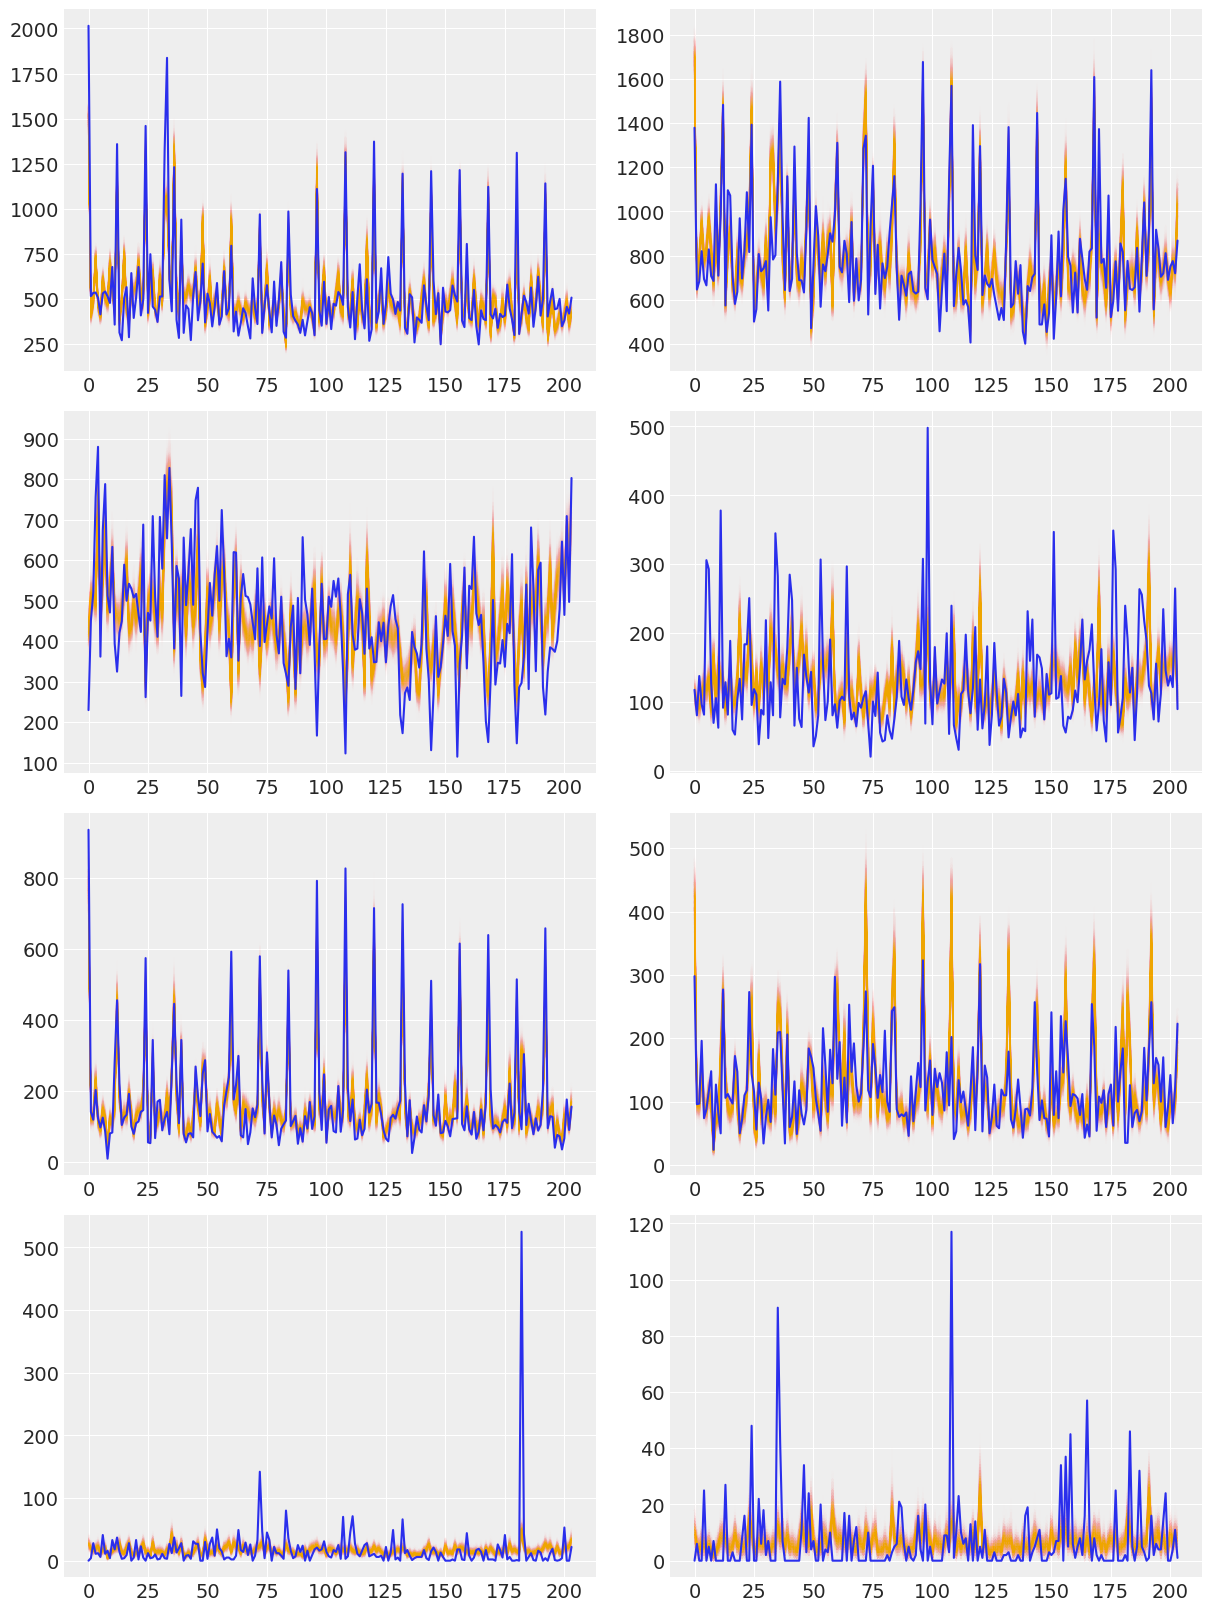

In [15]:
visualize_fit(groups, m.pred_samples_fit, 8)

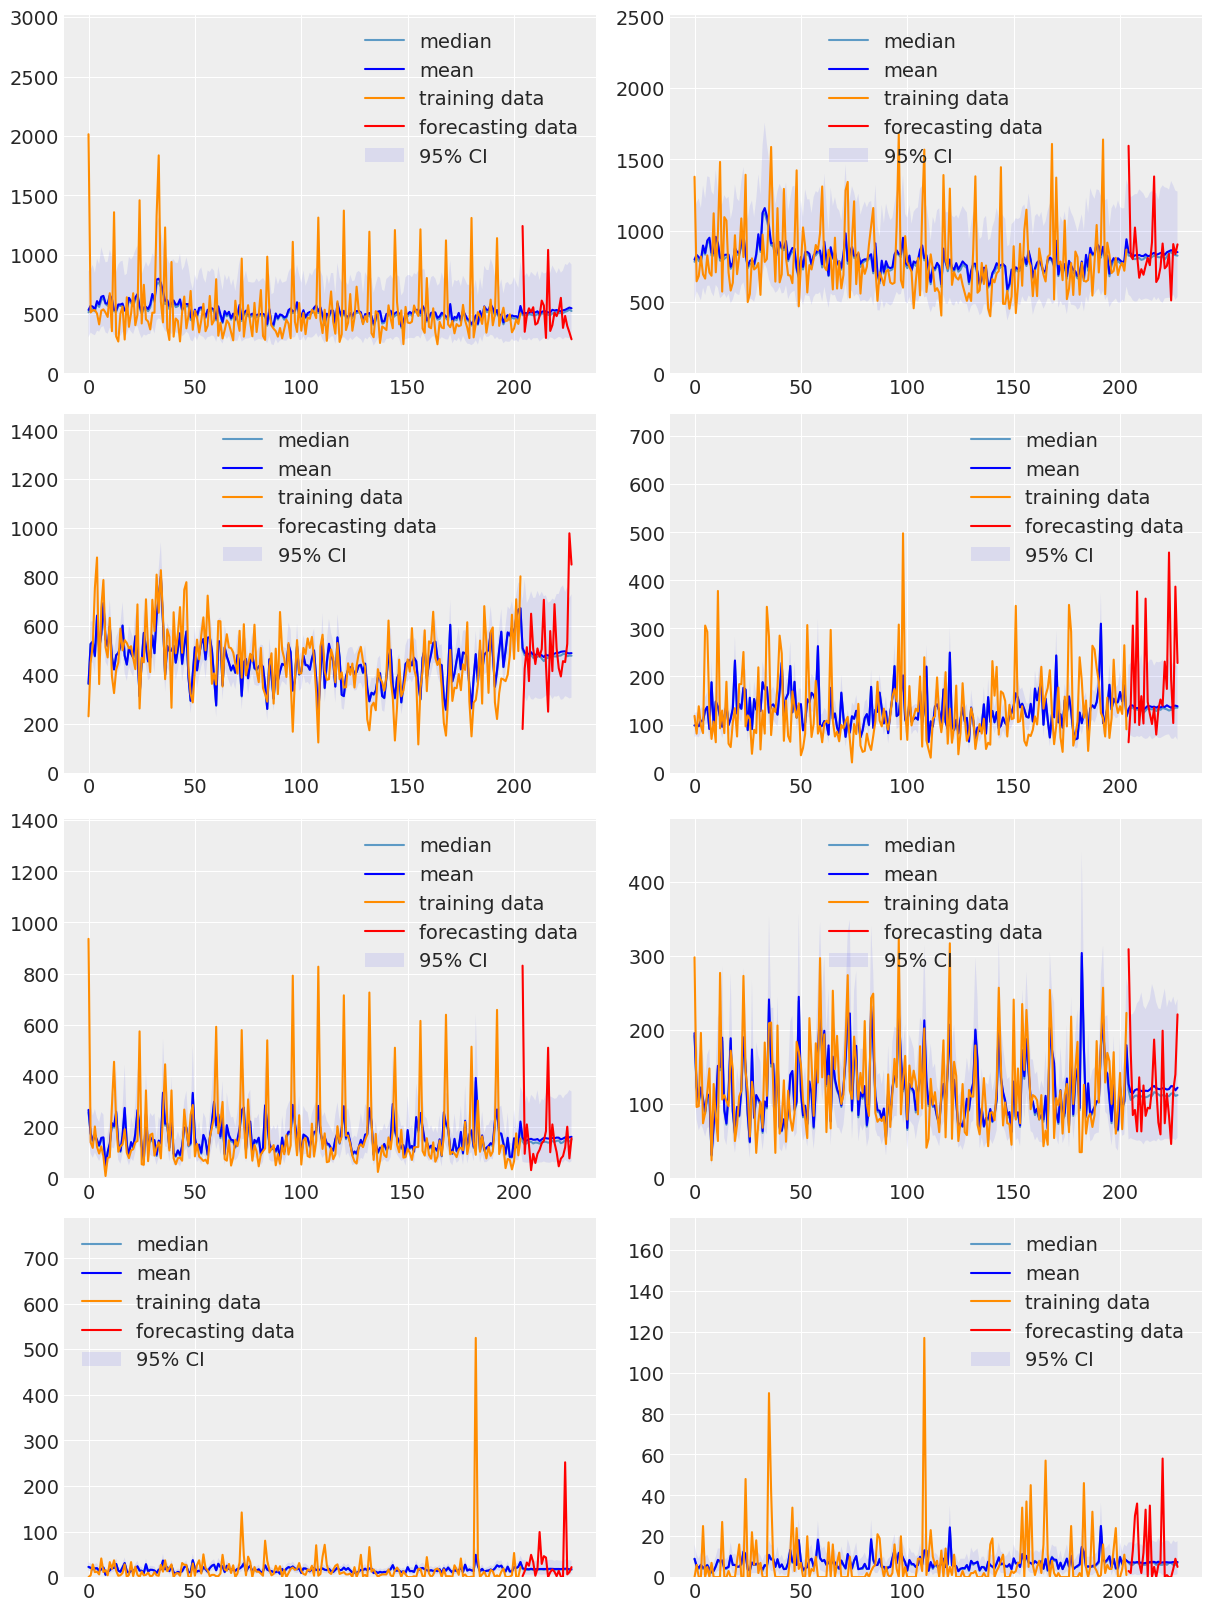

In [16]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [17]:
results = calculate_metrics(m.pred_samples_predict, groups)

In [18]:
metrics_to_table(groups, results)

# Using one more level of the hierarchy

In [13]:
m = HGPforecaster(groups_data=groups, 
                  levels=['state', 'zone', 'purpose']
                 )
m.fit()

Fitting model...



Sampling...


In [14]:
m.predict()

Sampling...


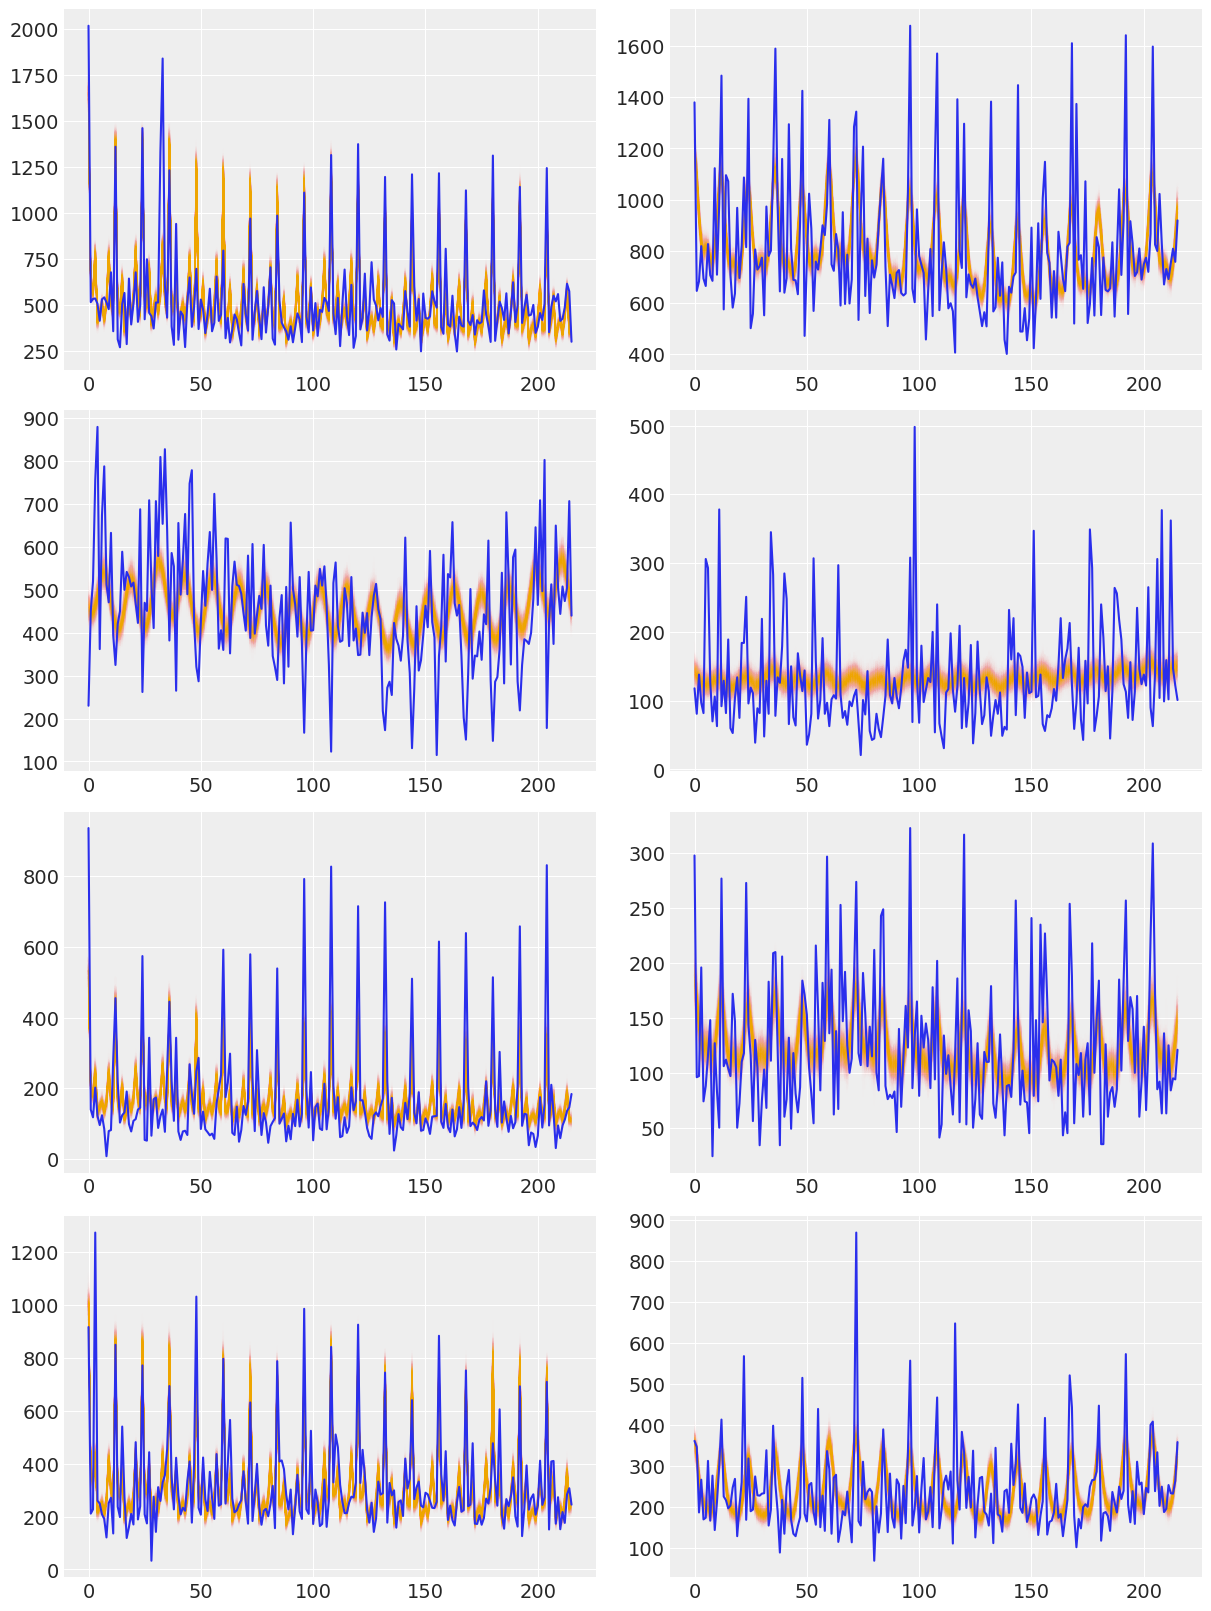

In [15]:
visualize_fit(groups, m.pred_samples_fit, 8)

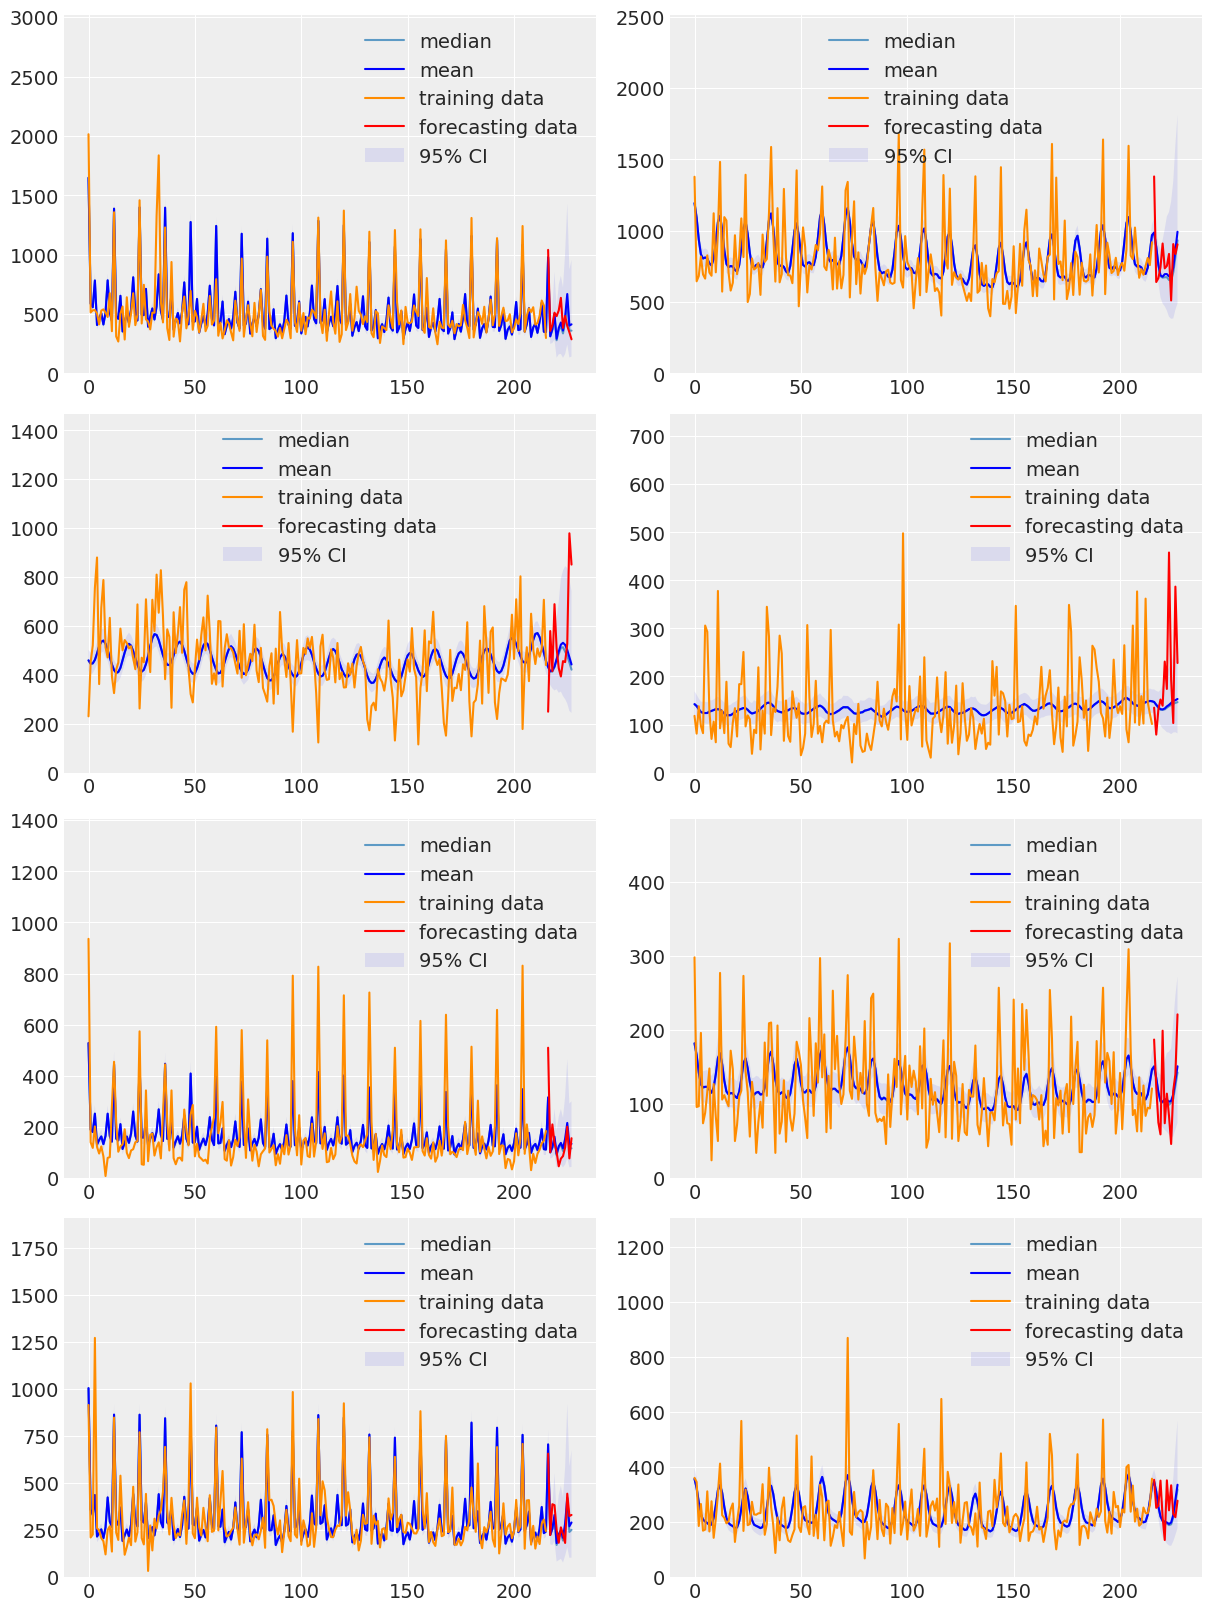

In [16]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [17]:
results = calculate_metrics(m.pred_samples_predict, groups)

In [18]:
metrics_to_table(groups, results)

# Using all levels of the hierarchy

In [19]:
m = HGPforecaster(groups_data=groups
                 )
m.fit()

Fitting model...



Sampling...


In [20]:
m.predict()

Sampling...


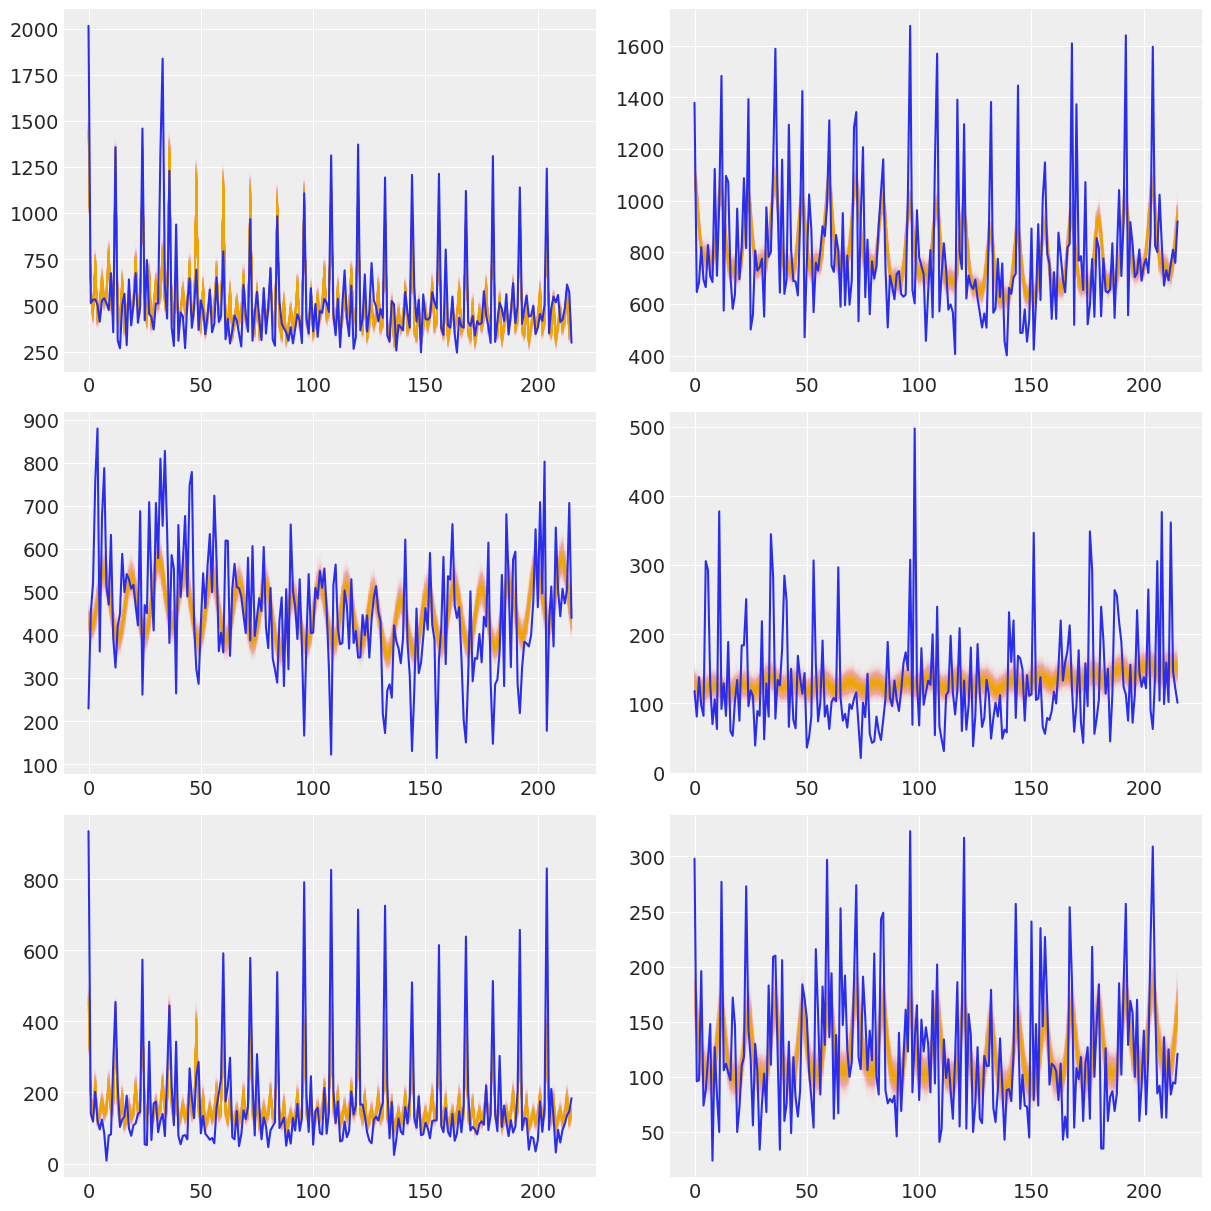

In [39]:
visualize_fit(groups, m.pred_samples_fit, 6)

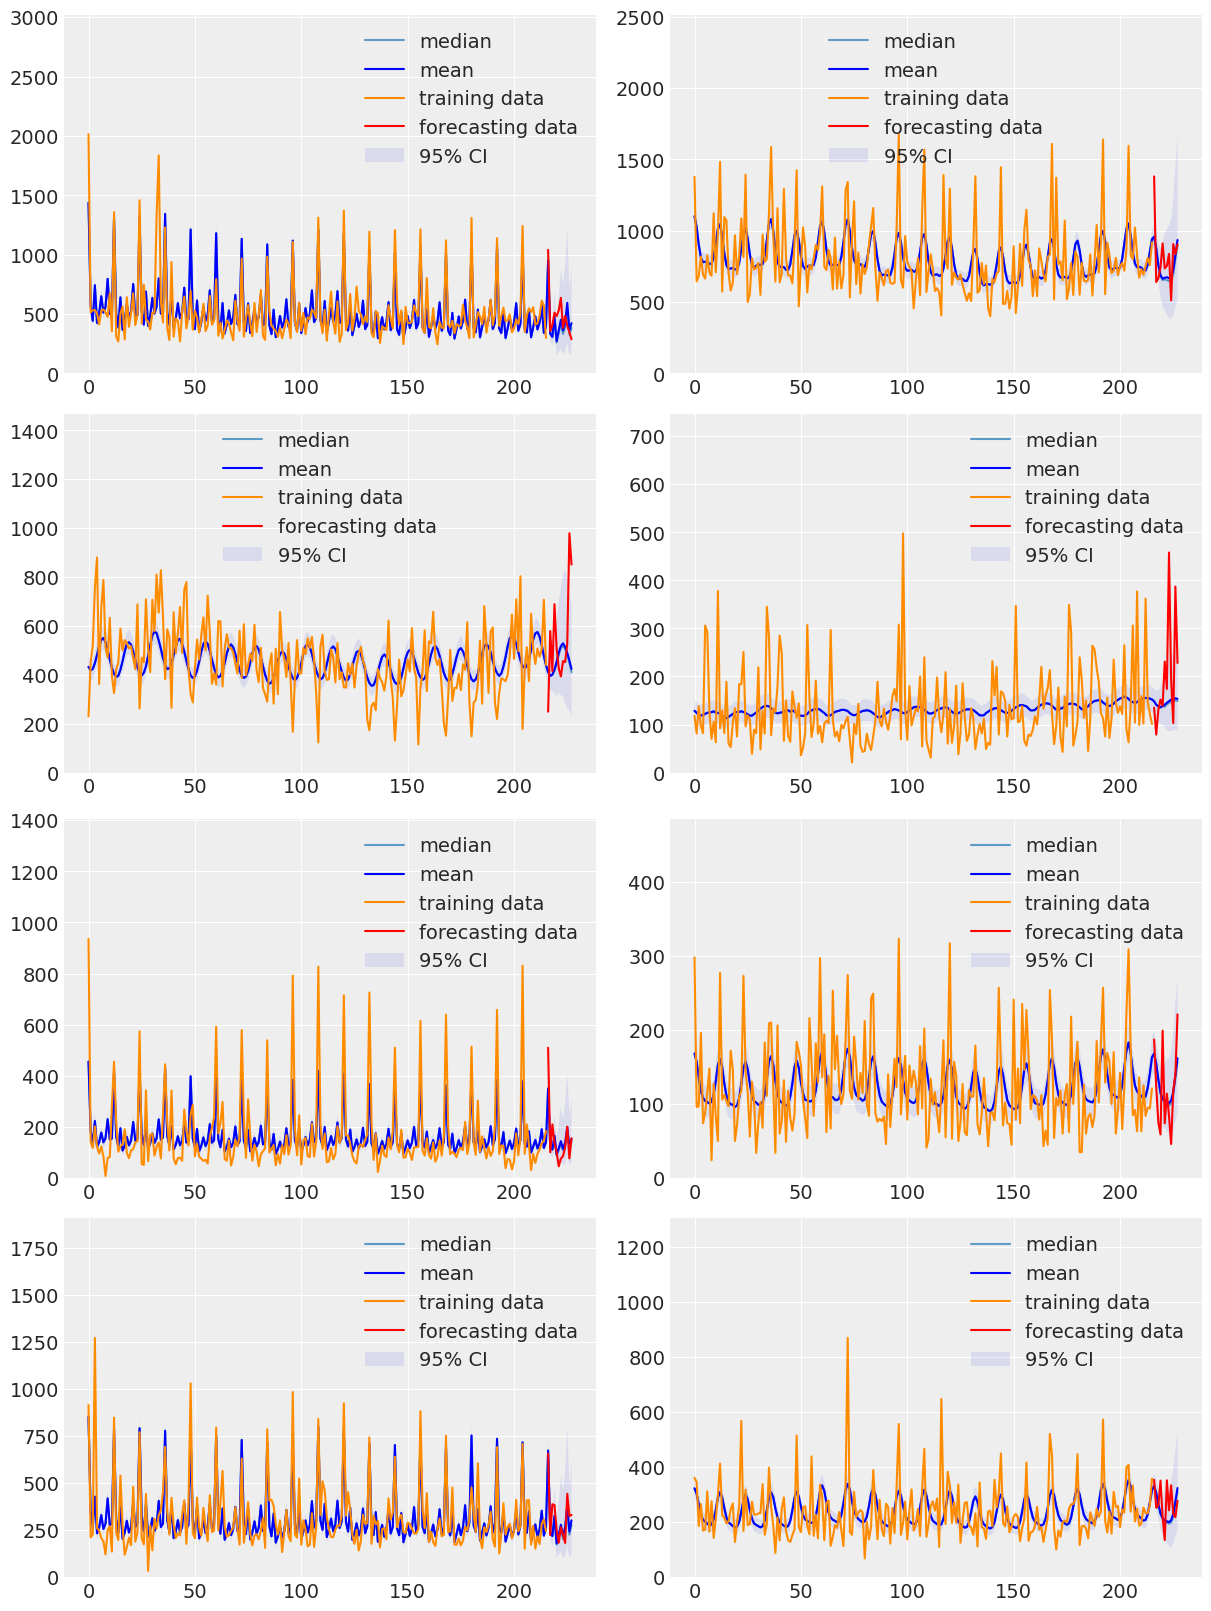

In [22]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [23]:
results = calculate_metrics(m.pred_samples_predict, groups)

In [24]:
metrics_to_table(groups, results)